## Problem

I want to practice SQL and Python on datasets resembling what I might encounter at a marketplace company like Uber, Lyft, or Doordash. The 538 [Uber Pickups in New York City](https://www.kaggle.com/fivethirtyeight/uber-pickups-in-new-york-city/data) dataset exists, but contains mostly location data:

In [1]:
import pandas as pd

In [2]:
foil_538 = pd.read_csv("data/uber/uber-foil.csv", parse_dates=["date"])
foil_538.head(3)

,dispatching_base_number,date,active_vehicles,trips
0,B02512,2015-01-01,190,1132
1,B02765,2015-01-01,225,1765
2,B02764,2015-01-01,3427,29421


In [3]:
dapr_538 = pd.read_csv("data/uber/uber-raw-apr14.csv", parse_dates=["Date/Time"])
dapr_538.head(3)

,Date/Time,Lat,Lon,Base
0,2014-04-01 00:11:00,40.7690,-73.9549,B02512
1,2014-04-01 00:17:00,40.7267,-74.0345,B02512
2,2014-04-01 00:21:00,40.7316,-73.9873,B02512


## Solution

Generate an entire universe of simulated marketplace data. Duh.

In this universe, our ridesharing data exists in four tables:

**trips**

* id - integer
* pilot - integer
* passenger - integer
* planet - id
* trip_completed - boolean
* trip_requested - timestamp
* trip_started - timestamp
* trip_ended - timestamp
* price - integer
* pilot_rating - integer
* passenger_rating - integer

**planets**

* id - integer
* name - string

**pilots**

* id - integer
* rating - integer
* banned - boolean
* created - timestamp

**passengers**

* id - integer
* rating - integer
* banned - boolean
* created - timestamp

Yes, when I said "universe" I meant it literally.

## Planets

* id - integer
* name - string

Let's start with planets, which seems like it should be pretty easy.

In [4]:
planets = ["Alderaan", "Chandrila", "Corellia", "Coruscant", "Duro", "Hosnian Prime", "Kuat"]

I know that I'm listing core worlds only, and I can already hear your accusations about my liberal core world elitism, but the reality is that worlds in the outer rim simply don't have the infrastructure to support ridesharing on the scale we're interested in. 

Pilots and passengers do occasionally arrange shared rides within and between systems, but these trips are usually negotiated in a more informal setting like, for example, a cantina.

In [5]:
df_planets = pd.DataFrame({"name": planets, "id": range(len(planets))})
df_planets

,id,name
0,0,Alderaan
1,1,Chandrila
2,2,Corellia
3,3,Coruscant
4,4,Duro
5,5,Hosnian Prime
6,6,Kuat


## Pilots

* id - integer
* rating - integer
* banned - boolean
* created - timestamp

Let's say that we have 100 pilots in our system. Pilot maintain a rating between 1 and 5 stars. Just like in our world, passengers in our simulated universe tend to be pretty nice when rating pilots, so distributions of pilot ratings are skewed towards the higher end.

In [6]:
%matplotlib inline
import numpy as np
import scipy.stats as stats

In [7]:
pilot_ratings = np.concatenate((
    stats.norm.rvs(loc=4.5, scale=0.3, size=70),
    stats.skewnorm.rvs(a=-1, loc=4, scale=1, size=30)
)).clip(0.01, 4.99)

df_pilots = pd.DataFrame({"rating" : pilot_ratings, "id": range(len(pilot_ratings))})

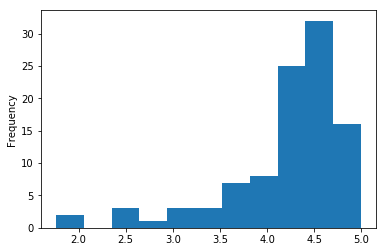

In [8]:
_ = df_pilots["rating"].plot(kind="hist", bins=11)

Some portion of pilots have been banned from our system. Pilots with low ratings are more likely to be banned.

In [9]:
df_pilots["banned"] = 0

pct_75 = df_pilots["rating"].quantile(0.75)
pct_50 = df_pilots["rating"].quantile(0.50)

pilots_abv_75th_pct = (df_pilots["rating"] >= pct_75)
pilots_abv_50th_pct = ((df_pilots["rating"] >= pct_50) & (df_pilots["rating"] < pct_75))
pilots_blw_50th_pct = (df_pilots["rating"] < pct_50)

df_pilots.loc[pilots_abv_75th_pct, "banned"] = np.random.choice([1, 0], size=25, p=[0.05, 0.95])
df_pilots.loc[pilots_abv_50th_pct, "banned"] = np.random.choice([1, 0], size=25, p=[0.10, 0.90]) 
df_pilots.loc[pilots_blw_50th_pct, "banned"] = np.random.choice([1, 0], size=50, p=[0.15, 0.85]) 

In [10]:
# do a stacked histogram here

Finally, let's uniformly distribute the time and day each pilot account was created throughout 2017 (yes, our simulated universe runs entirely on UTC it's really quite a remarkable feat of coordination):

In [11]:
import datetime, random

In [12]:
def timestamps_between(start, end, size):
    ts_start = int((start - datetime.datetime(1970, 1, 1)).total_seconds())
    duration = int((end - start).total_seconds())
    return np.array(random.sample(range(int(duration)), size)) + ts_start

In [13]:
str_2017 = datetime.datetime(2017, 1, 1, 0, 0, 0)
end_2017 = datetime.datetime(2017, 12, 31, 23, 59, 59)

In [14]:
pilot_timestamps = timestamps_between(str_2017, end_2017, 100)
df_pilots["created"] = pilot_timestamps

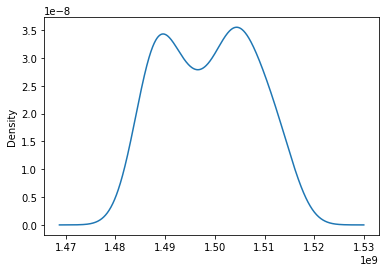

In [15]:
_ = df_pilots["created"].plot(kind="density")

In [16]:
df_pilots.head(3)

,id,rating,banned,created
0,0,4.042882,0,1514385527
1,1,4.630323,0,1492834087
2,2,4.115552,1,1506823703


Nice.

## Passengers

We're going to do the same for our 1,000 passengers, but relax the skew in the distribution of their ratings.

In [17]:
passenger_ratings = np.concatenate((
    stats.norm.rvs(loc=4.5, scale=0.3, size=500),
    stats.skewnorm.rvs(a=-1, loc=4, scale=1, size=500)
)).clip(0.01, 4.99)

df_passengers = pd.DataFrame({"rating": passenger_ratings, "id": range(len(passenger_ratings))})

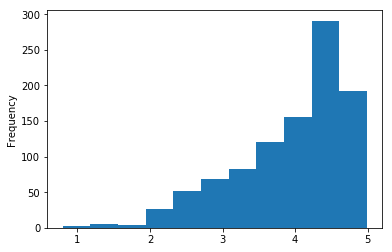

In [18]:
_ = df_passengers["rating"].plot(kind="hist", bins=11)

We'll also slightly reduce the probability of a passenger having been banned from the service...

In [19]:
df_passengers["banned"] = 0

pct_75 = df_passengers["rating"].quantile(0.75)
pct_50 = df_passengers["rating"].quantile(0.50)

passengers_abv_75th_pct = (df_passengers["rating"] >= pct_75)
passengers_abv_50th_pct = ((df_passengers["rating"] >= pct_50) & (df_passengers["rating"] < pct_75))
passengers_blw_50th_pct = (df_passengers["rating"] < pct_50)

df_passengers.loc[passengers_abv_75th_pct, "banned"] = np.random.choice([1, 0], size=250, p=[0.03, 0.97])
df_passengers.loc[passengers_abv_50th_pct, "banned"] = np.random.choice([1, 0], size=250, p=[0.07, 0.93]) 
df_passengers.loc[passengers_blw_50th_pct, "banned"] = np.random.choice([1, 0], size=500, p=[0.13, 0.87]) 

In [20]:
# stacked histogram!

... But keep the rules for account creation the same.

In [21]:
passenger_timestamps = timestamps_between(str_2017, end_2017, 1000)
df_passengers["created"] = passenger_timestamps

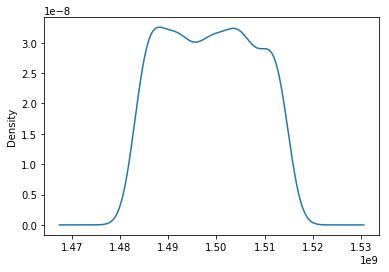

In [22]:
_ = df_passengers["created"].plot(kind="density")

In [23]:
df_passengers.head(3)

,id,rating,banned,created
0,0,4.848001,0,1491044851
1,1,4.433726,0,1506631773
2,2,4.896583,0,1500399633


## Trips

This is a big one. Let's break it down into several parts:

* id - integer
* pilot - integer
* passenger - integer
* planet - id

We can start by assigning pilots and passengers to planets. For sanity's sake, we'll make the assumption that neither pilots nor passengers ever participate in trips outside their home planets.

In [24]:
probs_planets = [0.05, 0.03, 0.18, 0.34, 0.10, 0.16, 0.14]

In [25]:
pilot_planets = pd.DataFrame({
    "pilot": df_pilots["id"],
    "planet": np.random.choice(df_planets["id"], size=len(df_pilots), p=probs_planets)
})

passenger_planets = pd.DataFrame({
    "passenger": df_passengers["id"],
    "planet": np.random.choice(df_planets["id"], size=len(df_passengers), p=probs_planets)
})

We'll suppose that 40% of our pilots are providing roughly 50% of the 10,000 trips.

In [26]:
def split_df(df, split_size):
    a = np.random.choice(df.index, size=split_size, replace=False)
    b = np.array(df.copy().drop(a).index)
    return a, b

In [51]:
pilots_40_idx, pilots_60_idx = split_df(df_pilots, 40)

trip_pilots = np.concatenate((
    np.random.choice(pilots_40_idx, size=5000, replace=True),
    np.random.choice(pilots_60_idx, size=5000, replace=True)
))

df_trips = pd.DataFrame({"pilot": trip_pilots, "id": range(len(trip_pilots))})

Which gives us a bimodal-looking distribution for trips per pilot:

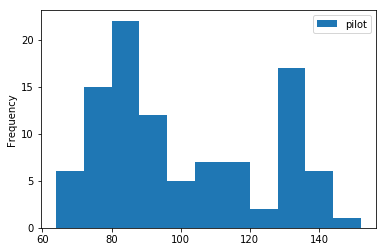

In [52]:
_ = pd.DataFrame(df_trips["pilot"].value_counts()).plot(kind="hist", bins=11)

Now let's assign a planet to each trip depending on the pilot's planet.

In [53]:
df_trips = pd.merge(df_trips, pilot_planets, how="left", on="pilot")

And assign passengers to trips that took place on their planet.

In [54]:
df_trips["passenger"] = None
for idx, row in df_trips.iterrows():
    passengers_from_planet = passenger_planets[passenger_planets["planet"] == row["planet"]]
    df_trips.loc[idx, "passenger"] = row["passenger"] = np.random.choice(passengers_from_planet["passenger"])

The way we do this results in a more normal-looking distribution for passenger trips:

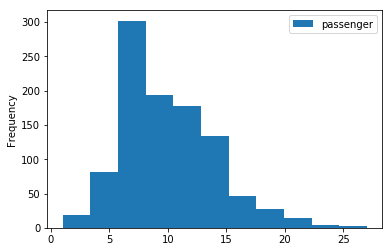

In [55]:
_ = pd.DataFrame(df_trips["passenger"].value_counts()).plot(kind="hist", bins=11)

In [56]:
df_trips.head(3)

,id,pilot,planet,passenger
0,0,95,5,153
1,1,32,2,401
2,2,43,6,734


* trip_completed - boolean
* trip_requested - timestamp
* trip_started - timestamp
* trip_ended - timestamp

Let's say the likelihood of a trip being completed is uniform across the population of trips.

In [57]:
trips_completed = stats.binom.rvs(n=1, p=0.95, size=len(df_trips))
df_trips["trip_completed"] = trips_completed

A trip can only be requested after both the pilot and passenger's accounts have been created.

In [58]:
max_trip = int((end_2017 - datetime.datetime(1970, 1, 1)).total_seconds())

In [59]:
for idx, row in df_trips.iterrows():
    
    pilot_created = df_pilots.loc[row["pilot"], "created"]
    passenger_created = df_passengers.loc[row["passenger"], "created"]
    min_trip = max(pilot_created, passenger_created)
    
    df_trips.loc[idx, "trip_requested"] = np.random.randint(min_trip, max_trip)

Remember that pilot and passenger account creation is distributed uniformly throughout the year. This means that trips become more likely to take place as the year goes on.

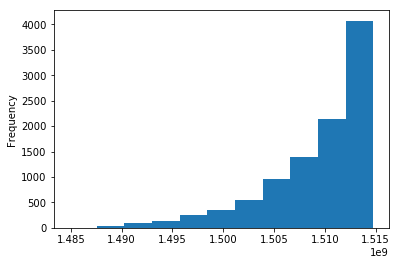

In [60]:
_ = df_trips.trip_requested.plot(kind="hist", bins=11)

Trips start between 1-15 minutes after they are requested.

In [61]:
for idx, row in df_trips.iterrows():
    df_trips.loc[idx, "trip_started"] = row["trip_requested"] + np.random.randint(60, 60 * 15)

And end between 5-60 minutes after they start.

In [62]:
for idx, row in df_trips.iterrows():
    df_trips.loc[idx, "trip_ended"] = row["trip_started"] + np.random.randint(60 * 5, 60 * 60)

Trips can have a start and end time without having been completed. What we *don't* want is for any pilot or passenger to have started a trip while in the middle of an ongoing trip. This is slightly trickier than it sounds, so let's go over it step by step.

First, we'll want an idea of how widespread the issue of overlapping trips is. Let's create a new dataframe, grouping trips provided by individual pilots and sorting them into chronological order.

In [174]:
trips_sorted_pilot = df_trips.sort_values(["pilot", "trip_requested"])

Let's examine the `trip_started` and `trip_ended` values in our new dataframe, and create some additional columns that will help us parse our timestamps more intuitively.

In [175]:
trips_sorted_pilot = pd.DataFrame({
    "id": trips_sorted_pilot["id"].values,
    "pilot": trips_sorted_pilot["pilot"].values,
    "trip_started": trips_sorted_pilot["trip_started"].values,
    "trip_ended": trips_sorted_pilot["trip_ended"].values,
    "trip_started_readable": pd.to_datetime(trips_sorted_pilot["trip_started"], unit="s").values,
    "trip_ended_readable": pd.to_datetime(trips_sorted_pilot["trip_ended"], unit="s").values
}, index=range(len(df_trips)))[["id", "pilot", "trip_started_readable", "trip_ended_readable", "trip_started", "trip_ended"]]

trips_sorted_pilot_duration = pd.DataFrame({"trip_duration": trips_sorted_pilot["trip_ended_readable"] - trips_sorted_pilot["trip_started_readable"]})
trips_sorted_pilot = pd.concat([trips_sorted_pilot, trips_sorted_pilot_duration], axis=1)

In [176]:
trips_sorted_pilot.head(3)

,id,pilot,trip_started_readable,trip_ended_readable,trip_started,trip_ended,trip_duration
0,3030,0,2017-12-27 15:05:24,2017-12-27 15:45:14,1.514387e+09,1.514390e+09,00:39:50
1,3975,0,2017-12-27 16:51:20,2017-12-27 17:22:25,1.514393e+09,1.514395e+09,00:31:05
2,4670,0,2017-12-27 18:01:05,2017-12-27 18:32:14,1.514398e+09,1.514400e+09,00:31:09


We can subtract from each row's `trip_started` time the `trip_ended` time of the previous row to get the time elapsed between the two trips. Any negative value returned by this calculation indicates an overlap.

In [177]:
%%time

trips_sorted_pilot["prev_trip_elapsed"] = None
trips_sorted_pilot["overlap"] = None

for idx, row in trips_sorted_pilot.iterrows():
    if idx == 0: continue
        
    curr_pilot = row["pilot"]
    prev_pilot = trips_sorted_pilot.loc[idx - 1]["pilot"]
    if curr_pilot != prev_pilot: continue
        
    prev_end = trips_sorted_pilot.loc[idx - 1]["trip_ended"]
    curr_str = row["trip_started"]
    elapsed = curr_str - prev_end
    trips_sorted_pilot.loc[idx, "prev_trip_elapsed"] = elapsed
    trips_sorted_pilot.loc[idx, "overlap"] = 1 if elapsed < 0 else 0

CPU times: user 27.9 s, sys: 294 ms, total: 28.2 s
Wall time: 29.5 s


In [182]:
trips_sorted_pilot.head(10)

,id,pilot,trip_started_readable,trip_ended_readable,trip_started,trip_ended,trip_duration,prev_trip_elapsed,overlap
0,3030,0,2017-12-27 15:05:24,2017-12-27 15:45:14,1.514387e+09,1.514390e+09,00:39:50,None,None
1,3975,0,2017-12-27 16:51:20,2017-12-27 17:22:25,1.514393e+09,1.514395e+09,00:31:05,3966,0
2,4670,0,2017-12-27 18:01:05,2017-12-27 18:32:14,1.514398e+09,1.514400e+09,00:31:09,2320,0
3,3017,0,2017-12-27 19:20:02,2017-12-27 20:06:26,1.514402e+09,1.514405e+09,00:46:24,2868,0
4,3990,0,2017-12-27 19:38:46,2017-12-27 19:58:49,1.514404e+09,1.514405e+09,00:20:03,-1660,1
5,751,0,2017-12-27 19:33:51,2017-12-27 20:20:45,1.514403e+09,1.514406e+09,00:46:54,-1498,1
6,4720,0,2017-12-27 23:09:45,2017-12-27 23:37:43,1.514416e+09,1.514418e+09,00:27:58,10140,0
7,3603,0,2017-12-27 23:52:04,2017-12-28 00:40:37,1.514419e+09,1.514422e+09,00:48:33,861,0
8,3402,0,2017-12-28 01:32:18,2017-12-28 02:11:00,1.514425e+09,1.514427e+09,00:38:42,3101,0
9,4746,0,2017-12-28 02:47:03,2017-12-28 03:00:12,1.514429e+09,1.514430e+09,00:13:09,2163,0


The later a pilot's account was created, the more likely they are to have an overlapping trip. 

At this point, I considered several strategies for dealing with the overlapping trips. Moving the start time of each trip some interval beyond of the end time of the previous trip, isolating the overlapping trips and generating new timestamps for them until no overlap remained in the dataframe, but after finding out that overlapping trips consisted of no more than 5% of our overall trips data...

In [187]:
float(trips_sorted_pilot["overlap"].sum()) / len(trips_sorted_pilot)

0.0433

... I decided that moving timestamps around was far more likely to create unintended patterns in our data and just dropped overlapping trips from the dataframe.

In [203]:
overlapping_trip_ids = trips_sorted_pilot[trips_sorted_pilot["overlap"] == 1]["id"].values
df_trips = df_trips.drop(overlapping_trip_ids)

Now we have to do the same for passengers - but fewer passengers should have overlapping trips since trips are spread out over a 10x greater number of passengers:

In [48]:
df_trips.head(3)

,pilot,planet,passenger,trip_completed,trip_requested,trip_started,trip_ended
0,43,6,928,1,1.512703e+09,1.512704e+09,1.512704e+09
1,70,6,634,1,1.505695e+09,1.505695e+09,1.505696e+09
2,31,6,394,1,1.508565e+09,1.508565e+09,1.508566e+09


* price - integer
* pilot_rating - integer
* passenger_rating - integer

Price is determined from the duration of the trip, and is slightly higher if the trip takes place during daylight hours.

We can use the same quantile groups to randomly assign a trip rating to pilots:

As well as passengers:

We have our datasets! SUCH BEAUTIES.

What kinds of questions can we try to answer with them?